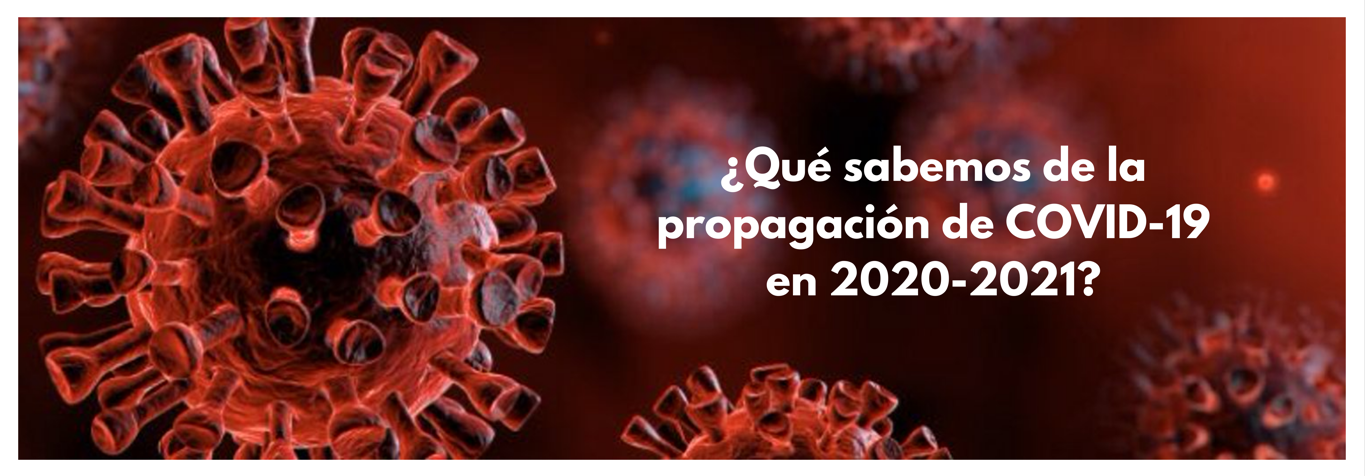

# Casos Globales de Covid-19:

## Resumen

Este análisis tiene como objetivo explorar las cifras de cotagios y muertes por coronavirus (SARS-CoV-2). Este virus fue tan relevante en el periodo de 2020- 2021, al provocar que gobiernos de todo el mundo tuviesen que promover (y, en algunos casos, incluso forzar) campañas de distanciamiento social entre sus habitantes.

A pesar de que los primeros casos se registraron en la provincia de Wuhan, China en diciembre de 2019. No existe información precisa de este primer momento y el registro de los Datos consultados comienza un mes después, en enero de 2020; los registros terminan en mayo de 2021, por lo que abarcan el periodo más crítico de la pandemia, previo al descubrimiento de las vacunas.

## Recursos

- Versión de Python: 3.7
- Librerías: Pandas, Plotly, Matplotlib, Seaborn, Numpy



In [276]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from datetime import datetime

In [277]:
link = 'https://docs.google.com/spreadsheets/d/10mlu_pYgiWhIJf6xX7C4YSbuRV0ymk0FAtvXY4dbr8w/edit?usp=sharing'
id = '10mlu_pYgiWhIJf6xX7C4YSbuRV0ymk0FAtvXY4dbr8w'

archivo = drive.CreateFile({'id':id}) 
archivo.GetContentFile('covid_19_data.csv', mimetype='text/csv') # Llama a 'mimetype' para descargar hoja de cálculo como csv
data_covid = pd.read_csv('covid_19_data.csv', encoding='utf-8')

## Análisis Exploratorio

En un primer vistazo, el DataFrame contiene las siguientes columnas:
- **SNo:** Índice explícito
- **ObservationDate:** Fecha censada en formato calendario
- **Province/State:** Provincia censada
- **Country/Regio:** País censado
- **Last Update:** Fecha de captura de registro en formato calendario, con hora
- **Confirmed:** Casos confirmados (acumulativos)
- **Deaths:** Muertes confirmadas (acumulativas)
- **Recovered:** Casos recuperados (acumulativos)

In [278]:
data_covid['ObservationDate'] = pd.to_datetime(data_covid['ObservationDate'])
data_covid['Last Update'] = pd.to_datetime(data_covid['Last Update'])

data_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306429 entries, 0 to 306428
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   SNo              306429 non-null  int64         
 1   ObservationDate  306429 non-null  datetime64[ns]
 2   Province/State   228329 non-null  object        
 3   Country/Region   306429 non-null  object        
 4   Last Update      306429 non-null  datetime64[ns]
 5   Confirmed        306429 non-null  int64         
 6   Deaths           306429 non-null  int64         
 7   Recovered        306429 non-null  int64         
dtypes: datetime64[ns](2), int64(4), object(2)
memory usage: 18.7+ MB


La única columna con valores nulos es la de *Provincia/Estado*, es conveniente determinar si se trata de una carencia generalizada o si existe algún patrón que pueda explicarla. Así, el 96.93% de los países censados tienen registros sin información de provincia.

Esto podría deberse a que las bases de datos de los sistemas de Salud globales no estaban preparados para recibir la cantidad de registros que tendrían que ponderar. Así, la información que proporcionaban las localidades se perdió, en algún momento, al conglomerarse en el censado nacional.

In [279]:
porcentaje_nulos = (data_covid['Country/Region'][data_covid['Province/State'].isnull()].nunique()/data_covid['Country/Region'].nunique()) * 100
print(f"{round(porcentaje_nulos, 2)}%")

96.93%


1 de cada 4 registros en la tabla carece de información de provincia, por lo que de entrada se conocen las limitaciones del análisis en cuanto a las localidades específicas de los casos de COVID-19.

In [280]:
print(f"{round(data_covid['Province/State'].isnull().sum()/len(data_covid)*100, 2)}%")

25.49%


## China

Se sabe que los primeros casos se dieron en Wuhan, China. Sin embargo, al revisar la cantidad de casos registrados en *China*, sólo existen 48. Esto se debe a factores históricos y políticos de la región, que no son evidentes, a simple vista, al revisar la lista de países registrados:

In [281]:
data_covid[data_covid['Country/Region'] == 'China'].shape[0]

48

De entrada, aparecen al menos *Mainland China*, *Hong Kong*, *Macau* y *Taiwan* como territorios chinos. 

A simple vista, es posible apreciar que este no es el único caso y que el DataFrame tendría que limpiarse para llegar a mejores conclusiones regionales. Teniendo en cuenta que los valores, tal cual están registrados, servirían mejor para análisis comparativos entre poblaciones similares administradas por diferentes gobiernos (y cómo las políticas de los organismos de salud, de estos gobiernos, influyeron en las cifras).

In [282]:
data_covid['Country/Region'].unique()

array(['Mainland China', 'Hong Kong', 'Macau', 'Taiwan', 'US', 'Japan',
       'Thailand', 'South Korea', 'China', 'Kiribati', 'Singapore',
       'Philippines', 'Malaysia', 'Vietnam', 'Australia', 'Mexico',
       'Brazil', 'Colombia', 'France', 'Nepal', 'Canada', 'Cambodia',
       'Sri Lanka', 'Ivory Coast', 'Germany', 'Finland',
       'United Arab Emirates', 'India', 'Italy', 'UK', 'Russia', 'Sweden',
       'Spain', 'Belgium', 'Others', 'Egypt', 'Iran', 'Israel', 'Lebanon',
       'Iraq', 'Oman', 'Afghanistan', 'Bahrain', 'Kuwait', 'Austria',
       'Algeria', 'Croatia', 'Switzerland', 'Pakistan', 'Georgia',
       'Greece', 'North Macedonia', 'Norway', 'Romania', 'Denmark',
       'Estonia', 'Netherlands', 'San Marino', 'Azerbaijan', 'Belarus',
       'Iceland', 'Lithuania', 'New Zealand', 'Nigeria', 'North Ireland',
       'Ireland', 'Luxembourg', 'Monaco', 'Qatar', 'Ecuador',
       'Czech Republic', 'Armenia', 'Dominican Republic', 'Indonesia',
       'Portugal', 'Andorra', '

In [283]:
china = data_covid[(data_covid['Country/Region'] == 'China') | (data_covid['Country/Region'] == 'Mainland China') | 
                   (data_covid['Country/Region'] == 'Hong Kong') | (data_covid['Country/Region'] == 'Macau') | 
                   (data_covid['Country/Region'] == 'Taiwan')]

china.groupby('Country/Region')['Confirmed'].sum()

Country/Region
China                    0
Hong Kong          2655935
Macau                20605
Mainland China    40822596
Taiwan              339919
Name: Confirmed, dtype: int64

Gracias a esta exploración, encontramos que los valores registrados para *China* **no** contienen información importante de casos confirmados, y, por lo tanto, tampoco de muertes o de casos recuperados.

In [284]:
china[china['Country/Region'] == 'China']

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
38,39,2020-01-22,Unknown,China,2020-01-22 17:00:00,0,0,0
86,87,2020-01-23,Unknown,China,2020-01-23 17:00:00,0,0,0
129,130,2020-01-24,Unknown,China,2020-01-24 17:00:00,0,0,0
175,176,2020-01-25,Unknown,China,2020-01-25 17:00:00,0,0,0
224,225,2020-01-26,Unknown,China,2020-01-26 16:00:00,0,0,0
277,278,2020-01-27,Unknown,China,2020-01-27 23:59:00,0,0,0
331,332,2020-01-28,Unknown,China,2020-01-28 23:00:00,0,0,0
387,388,2020-01-29,Unknown,China,2020-01-29 19:30:00,0,0,0
447,448,2020-01-30,Unknown,China,2020-01-30 16:00:00,0,0,0
511,512,2020-01-31,Unknown,China,2020-01-31 23:59:00,0,0,0


Tras este descubrimiento, es posible borrar las columnas de *China*, sabiendo que la información relevante quedará intacta.

In [285]:
china = china.drop(columns='SNo').set_index('Country/Region').drop('China')

china.groupby('Country/Region')['Confirmed'].sum()

Country/Region
Hong Kong          2655935
Macau                20605
Mainland China    40822596
Taiwan              339919
Name: Confirmed, dtype: int64

¿Existirán otros registros con 0 confirmados? Efectivamente, hay 4,741 registros que no aportan información confiable... por el contrario, incluso existen países que han reportado muertes o casos recuperados, sin dar cifras de casos confirmados.

In [286]:
data_covid[data_covid['Confirmed'] == 0]

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
4,5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0,0,0
10,11,2020-01-22,Heilongjiang,Mainland China,2020-01-22 17:00:00,0,0,0
12,13,2020-01-22,Hong Kong,Hong Kong,2020-01-22 17:00:00,0,0,0
15,16,2020-01-22,Inner Mongolia,Mainland China,2020-01-22 17:00:00,0,0,0
18,19,2020-01-22,Jilin,Mainland China,2020-01-22 17:00:00,0,0,0
...,...,...,...,...,...,...,...,...
306368,306369,2021-05-29,Unknown,Mainland China,2021-05-30 04:20:55,0,0,10
306369,306370,2021-05-29,Unknown,Mexico,2021-05-30 04:20:55,0,0,1924865
306371,306372,2021-05-29,Unknown,Peru,2021-05-30 04:20:55,0,0,1897522
306372,306373,2021-05-29,Unknown,Spain,2021-05-30 04:20:55,0,0,0


## México

México presenta una cantidad significativa de estos registros cuestionables, es relevante saber qué porcentaje de los registros mexicanos presentan incongruencias entre la cantidad de casos confirmados frente a las de muertes y recuperados.

Sólo 1 de los 200 registros con cero casos confirmados tiene también cero muertes y cero casos recuperados, afortunadamente esto representa apenas el 1.63% de la información presentada por las autoridades de este país.

In [287]:
data_covid[(data_covid['Confirmed'] == 0) & (data_covid['Deaths'] == 0) & (data_covid['Recovered'] == 0) & (data_covid['Country/Region'] == 'Mexico')].shape[0]

1

In [288]:
round(data_covid[(data_covid['Confirmed'] == 0) & (data_covid['Country/Region'] == 'Mexico')].shape[0] / data_covid[data_covid['Country/Region'] == 'Mexico'].shape[0] * 100, 2)

1.63

Al graficar existen nuevamente incongruencias en los casos confirmados, recuperados y las muertes por COVID.

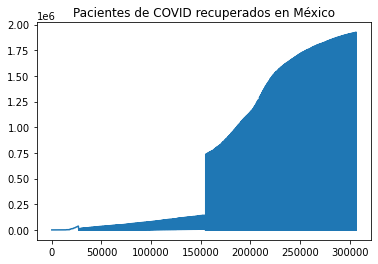

In [289]:
data_covid[data_covid['Country/Region'] == 'Mexico'].Recovered.plot.line(title = 'Pacientes de COVID recuperados en México')

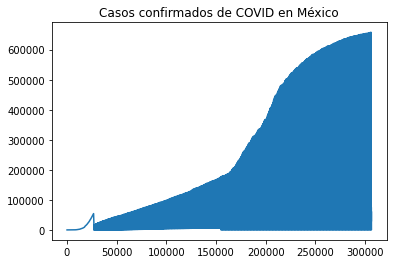

In [290]:
data_covid[data_covid['Country/Region'] == 'Mexico'].Confirmed.plot.line(title = 'Casos confirmados de COVID en México')

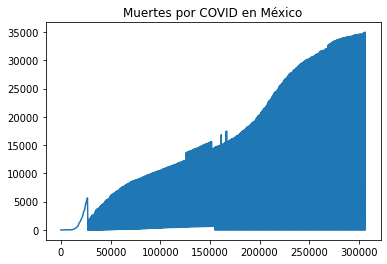

In [291]:
data_covid[data_covid['Country/Region'] == 'Mexico'].Deaths.plot.line(title = 'Muertes por COVID en México')

## Limpieza de Tabla

A partir de lo anterior, y, al ordenar la tabla por número de casos confirmados, queda claro que los valores por debajo de cero son una inconsistencia que va más allá de un par de países. ¡Incluso existen columnas con valores negativos!

Es conveniente remover estos registros, pues no tiene sentido que existan valores menores a uno en la columna de datos confirmados, ni que existan valores menores a cero en las columnas de muertes y pacientes recuperados.

In [292]:
data_covid.sort_values(by = ['Confirmed'], ascending = False)

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
298068,298069,2021-05-19,NaN,France,2021-05-20 04:21:05,5863138,107390,324444
297303,297304,2021-05-18,NaN,France,2021-05-19 04:20:42,5845010,107256,323205
296538,296539,2021-05-17,NaN,France,2021-05-18 04:20:33,5829009,107041,321874
295773,295774,2021-05-16,NaN,France,2021-05-17 04:20:34,5825659,106845,321026
295008,295009,2021-05-15,NaN,France,2021-05-16 04:20:49,5811711,106764,320711
...,...,...,...,...,...,...,...,...
257404,257405,2021-03-26,Unknown,Colombia,2021-04-02 15:13:53,0,0,0
257406,257407,2021-03-26,Unknown,India,2021-04-02 15:13:53,0,0,0
257408,257409,2021-03-26,Unknown,Mainland China,2021-04-02 15:13:53,0,0,3
257409,257410,2021-03-26,Unknown,Mexico,2021-04-02 15:13:53,0,0,1755798


In [293]:
data_covid = data_covid[(data_covid['Confirmed'] > 0) & (data_covid['Deaths'] >= 0) & (data_covid['Recovered'] >= 0)]

data_covid

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1,0,0
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14,0,0
2,3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6,0,0
3,4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1,0,0
5,6,2020-01-22,Guangdong,Mainland China,2020-01-22 17:00:00,26,0,0
...,...,...,...,...,...,...,...,...
306424,306425,2021-05-29,Zaporizhia Oblast,Ukraine,2021-05-30 04:20:55,102641,2335,95289
306425,306426,2021-05-29,Zeeland,Netherlands,2021-05-30 04:20:55,29147,245,0
306426,306427,2021-05-29,Zhejiang,Mainland China,2021-05-30 04:20:55,1364,1,1324
306427,306428,2021-05-29,Zhytomyr Oblast,Ukraine,2021-05-30 04:20:55,87550,1738,83790


Por último, la columna *SNo* es redundante y no aporta información relevante:

In [294]:
data_covid = data_covid.drop('SNo', axis=1)

Es momento de crear columnas que faciliten la visualización de información. En primer lugar, una nueva columna llamada *FirstConfirmed*, en donde se capture **por país** el primer día de registros, que, ahora que los datos numéricos son consistentes, coincidirá con el día en que se presentaron los primeros casos en cada país.

Una muestra aleatoria confirma rápidamente la diferencia entre fechas en que cada país presentó sus primeros casos.

In [295]:
data_covid['FirstConfirmed'] = data_covid.groupby('Country/Region')['ObservationDate'].transform('min')

data_covid.sample(50, random_state = 36)

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,FirstConfirmed
53290,2020-06-29,Dnipropetrovsk Oblast,Ukraine,2021-04-02 15:13:53,1087,23,913,2020-03-03
90335,2020-08-18,Chechen Republic,Russia,2021-04-02 15:13:53,2200,37,1487,2020-01-31
288712,2021-05-06,Sichuan,Mainland China,2021-05-07 04:20:40,992,3,958,2020-01-22
61267,2020-07-10,Atlantico,Colombia,2021-04-02 15:13:53,30617,1776,11980,2020-03-06
233043,2021-02-23,NaN,France,2021-04-02 15:13:53,3608271,84610,226208,2020-01-24
93484,2020-08-22,Ladakh,India,2021-04-02 15:13:53,2210,21,1469,2020-01-30
134989,2020-10-17,NaN,Rwanda,2021-04-02 15:13:53,4971,34,4768,2020-03-14
143961,2020-10-29,NaN,Paraguay,2021-04-02 15:13:53,62050,1373,41800,2020-03-08
3698,2020-03-06,NaN,Malaysia,2020-03-06 12:33:03,83,0,22,2020-01-25
295557,2021-05-15,Rio Grande do Sul,Brazil,2021-05-16 04:20:49,1031239,26657,986766,2020-02-26


Sin embargo, la visualización podría ser más clara al añadir también una columna *OngoingDays*, que muestre cuántos días han pasado del primer contagio por país.

In [296]:
data_covid['OngoingDays'] = (data_covid['ObservationDate'] - data_covid['FirstConfirmed']).dt.days

Ahora, con un criterio común para comparar el crecimiento de contagios entre los diferentes países, es posible visualizar cómo fue el comportamiento de los contagios en un día particular.

E.g., ¿cuáles países confirmaban la mayor y menor cantidad de contagios en su día 100 (a partir del primer contagio en su territorio)?

In [297]:
dia_100 = data_covid[data_covid['OngoingDays'] == 100]

data_100 = pd.DataFrame(dia_100[['Country/Region', 'Confirmed']].sort_values('Confirmed'))
data_100 = data_100.set_index('Country/Region').sort_values('Confirmed')
data_100

,Confirmed
Country/Region,
Micronesia,1
Vanuatu,1
Mainland China,1
Colombia,1
France,1
...,...
Russia,209688
Italy,219070
UK,219183


## Análisis global

**¿Cuántos casos globales se confirmaron a la fecha de la última actualización?**

En primer lugar, agrupar por *Fecha de Observación*, permitirá acceder directamente a las cifras globales diarias.

In [298]:
data_covid.groupby('ObservationDate').sum()

,Confirmed,Deaths,Recovered,OngoingDays
ObservationDate,,,,
2020-01-22,557,17,30,0
2020-01-23,1097,34,60,34
2020-01-24,941,26,39,75
2020-01-25,1437,42,42,118
2020-01-26,2118,56,56,170
...,...,...,...,...
2021-05-25,167848207,3485787,102906967,351009
2021-05-26,168416423,3498543,103460918,351766
2021-05-27,168970791,3511296,104156582,352523


Cada conjunto de cifras responderá diferentes preguntas y apoyará distintos análisis, por tanto, es conveniente almacenarles en variables específicas a llamar. En este caso, el total de casos confirmados en todo el mundo:

In [299]:
confirmados = data_covid.groupby('ObservationDate').sum()['Confirmed'].reset_index()
muertes = data_covid.groupby('ObservationDate').sum()['Deaths'].reset_index()
recuperados = data_covid.groupby('ObservationDate').sum()['Recovered'].reset_index()

confirmados['Confirmed'].sum()

26252354602

**¿Cuántas muertes por COVID se registraron?**

In [300]:
muertes['Deaths'].sum()

624006666

**¿Cuántos pacientes se recuperaron?**

In [301]:
recuperados['Recovered'].sum()

14413604917

**¿En qué proporción murieron y se recuperaron los pacientes contagiados?**

In [302]:
tasa_m = round((muertes['Deaths'].sum() / confirmados['Confirmed'].sum()) * 100, 2)
tasa_r = round((recuperados['Recovered'].sum() / confirmados['Confirmed'].sum()) * 100, 2)

print(f'Se ha reportado que {tasa_m}% de los pacientes murieron y {tasa_r}% se recuperaron.')

Se ha reportado que 2.38% de los pacientes murieron y 54.9% se recuperaron.


In [303]:
graf_1 = go.Bar(x = confirmados['ObservationDate'],
              y = confirmados['Confirmed'],
              name = 'Confirmados',
              marker_color = 'purple')

graf_2 = go.Bar(x = muertes['ObservationDate'],
              y = muertes['Deaths'],
              name = 'Muertes',
              marker_color = 'orange')

graf_3 = go.Bar(x = recuperados['ObservationDate'],
              y = recuperados['Recovered'],
              name = 'Recuperados',
              marker_color = 'green')

layout = go.Layout(barmode = 'group',
                  title = 'Worldwide Corona Virus Cases - Confirmados, Deaths, Recovered (Bar Chart)',
                  xaxis = dict(title='Mes/Año',zeroline= True,
                         gridcolor='white',
                               showline=True),
                  yaxis = dict(title='Casos registrados',zeroline= False,
                            gridcolor='white',showline=True)
)

data = [graf_1, graf_2, graf_3]
fig = go.Figure(data = data, layout = layout)
fig.show() # En caso que la gráfica no se despliegue adecuadamente, añadir parametro: renderer = 'colab'

## Análisis por país

Al realizar la misma métrica, pero por países, es fácil visualizar cuáles son los países con más y menos casos de COVID, respectivamente:

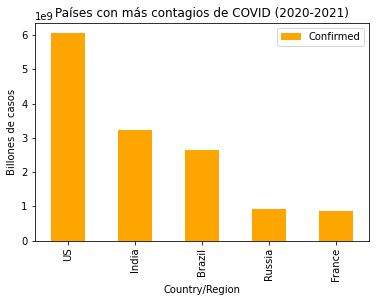

In [350]:
conf_pais = data_covid.groupby('Country/Region').sum()['Confirmed'].reset_index()
conf_pais = conf_pais.set_index('Country/Region').sort_values('Confirmed', ascending = False)

fig = conf_pais.head().plot.bar(color = 'orange')
fig.set(ylabel='Billones de casos', title='Países con más contagios de COVID (2020-2021)')

fig

Con este mismo formato, se pueden visualizar las cifras de los países con más muertes y casos recuperados:

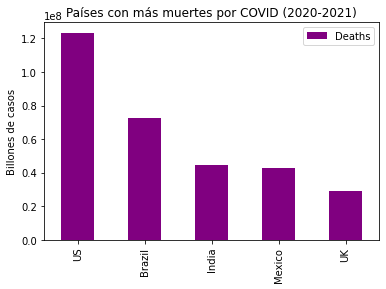

In [349]:
mort_pais = data_covid.groupby('Country/Region').sum()['Deaths'].reset_index()
mort_pais = mort_pais.set_index('Country/Region').sort_values('Deaths', ascending = False)

fig = mort_pais.head().plot.bar(color = 'purple')
fig.set(xlabel='', ylabel='Billones de casos', title='Países con más muertes por COVID (2020-2021)')

fig

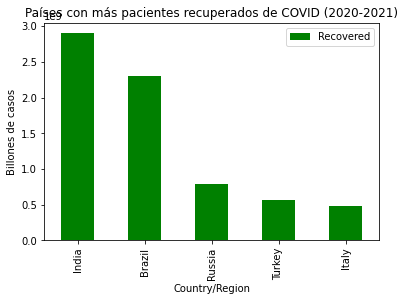

In [348]:
recuperados_pais = data_covid.groupby('Country/Region').sum()['Recovered'].reset_index()
recuperados_pais = recuperados_pais.set_index('Country/Region').sort_values('Recovered', ascending = False)

fig = recuperados_pais.head().plot.bar(color = 'green')
fig.set(ylabel='Billones de casos', title='Países con más pacientes recuperados de COVID (2020-2021)')

fig

# Hola, mi nombre es Sarahí Sancliment 👋

## 🚀 Acerca de mí
Soy analista de datos en proceso, con experiencia en la investigación académica en el área de la Filosofía y las Ciencias Sociales. Tengo el ojo bien puesto en llevar esos talentos al mundo de la programación.

## 🔗 ¿Platicamos?
### sasn6970@protonmail.com 
#### (+52) 55-3247-2299
[![linkedin](https://img.shields.io/badge/linkedin-0A66C2?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/sara-sancliment-garcia-4336b1235/)
[![github](https://img.shields.io/badge/github-1DA1F2?style=for-the-badge&logo=github&logoColor=white)](https://github.com/sasn6970)